# Unravel - Garment Deconstruction
This notebook contains the initial implementation of Unravel, a tool for deconstructing and describing both garments and outfits. There are two primary use cases for this product: (1) deconstructing an individual garment, quantifying sleeves, cuffs, buttons, and more; and (2) deconstructing an outfit, providing stylistic qualifiers and descriptors. 

## Module Imports

In [1]:
import requests
import torch 
torch.hub.set_dir('/share/ju/tmp_dir_location/')
from PIL import Image
import cv2
import matplotlib.pyplot as plt 
import numpy as np
from pathlib import Path
# Facebook's Segment Anything Model
from segment_anything import sam_model_registry, SamPredictor, SamAutomaticMaskGenerator
from lavis.models import load_model_and_preprocess
import pandas as pd

/share/ju/conda_virtualenvs/lavis/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Helper Functions

In [2]:
# Borrowed from Segment Anything tutorial code
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)
    polygons = []
    color = []
    for ann in sorted_anns:
        m = ann['segmentation']
        img = np.ones((m.shape[0], m.shape[1], 3))
        color_mask = np.random.random((1, 3)).tolist()[0]
        for i in range(3):
            img[:,:,i] = color_mask[i]
        ax.imshow(np.dstack((img, m*0.35)))

In [3]:
# Borrowed from tutorial code
def boundary(inputs):
    
    col = inputs.shape[1]
    inputs = inputs.reshape(-1)
    lens = len(inputs)
    start = np.argmax(inputs)
    end = lens - 1 - np.argmax(np.flip(inputs))
    top = start // col
    bottom = end // col
    
    return top, bottom

def seg_to_box(seg_mask, size):
    
    top, bottom = boundary(seg_mask)
    left, right = boundary(seg_mask.T)
    left, top, right, bottom = left / size, top / size, right / size, bottom / size # we normalize the size of boundary to 0 ~ 1

    return [left, top, right, bottom]

In [4]:
def classify_garment(taxonomy):
    print(taxonomy.keys())
    # run zero-shot classification on taxonomy.keys(): 
    # take maximum probability score 
    # debug max_cls as first key for now
    max_cls = next(iter(taxonomy.keys()))
    print(taxonomy[max_cls])
    #while taxonomy[max_cls]: 
    if taxonomy[max_cls]:
        classify_garment(taxonomy[max_cls])

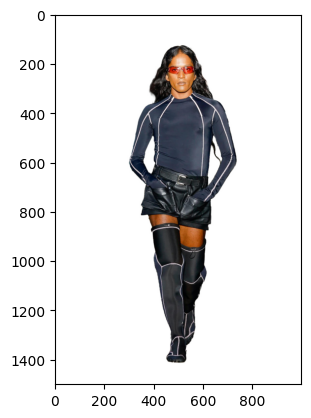

In [5]:
# Read in an image to segment
IMG_PATH = '/share/ju/segmentation/unravel/test_images/look0022_nobg.jpg'
image = cv2.imread(IMG_PATH)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# preview the image 
height, width, channel = image.shape
plt.imshow(image)

In [6]:
# parameters
device = "cuda" if torch.cuda.is_available() else "cpu"
torch_dtype = torch.float16 if 'cuda' in device else torch.float32
model_type = 'vit_h'
checkpoint = '/share/ju/segmentation/caption-anything/segmenter/sam_vit_h_4b8939.pth'

# SAM initialization
model = sam_model_registry[model_type](checkpoint = checkpoint)
model.to(device)
predictor = SamPredictor(model)
mask_generator = SamAutomaticMaskGenerator(model, points_per_side=16, min_mask_region_area=100, crop_n_layers=0, box_nms_thresh=0.7, points_per_batch=32)
"""
        Using a SAM model, generates masks for the entire image.
        Generates a grid of point prompts over the image, then filters
        low quality and duplicate masks. The default settings are chosen
        for SAM with a ViT-H backbone.
        Arguments:
          model (Sam): The SAM model to use for mask prediction.
          points_per_side (int or None): The number of points to be sampled
            along one side of the image. The total number of points is
            points_per_side**2. If None, 'point_grids' must provide explicit
            point sampling.
          points_per_batch (int): Sets the number of points run simultaneously
            by the model. Higher numbers may be faster but use more GPU memory.
          pred_iou_thresh (float): A filtering threshold in [0,1], using the
            model's predicted mask quality.
          stability_score_thresh (float): A filtering threshold in [0,1], using
            the stability of the mask under changes to the cutoff used to binarize
            the model's mask predictions.
          stability_score_offset (float): The amount to shift the cutoff when
            calculated the stability score.
          box_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks.
          crop_n_layers (int): If >0, mask prediction will be run again on
            crops of the image. Sets the number of layers to run, where each
            layer has 2**i_layer number of image crops.
          crop_nms_thresh (float): The box IoU cutoff used by non-maximal
            suppression to filter duplicate masks between different crops.
          crop_overlap_ratio (float): Sets the degree to which crops overlap.
            In the first crop layer, crops will overlap by this fraction of
            the image length. Later layers with more crops scale down this overlap.
          crop_n_points_downscale_factor (int): The number of points-per-side
            sampled in layer n is scaled down by crop_n_points_downscale_factor**n.
          point_grids (list(np.ndarray) or None): A list over explicit grids
            of points used for sampling, normalized to [0,1]. The nth grid in the
            list is used in the nth crop layer. Exclusive with points_per_side.
          min_mask_region_area (int): If >0, postprocessing will be applied
            to remove disconnected regions and holes in masks with area smaller
            than min_mask_region_area. Requires opencv.
          output_mode (str): The form masks are returned in. Can be 'binary_mask',
            'uncompressed_rle', or 'coco_rle'. 'coco_rle' requires pycocotools.
            For large resolutions, 'binary_mask' may consume large amounts of
            memory.
        """
predictor.set_image(np.array(image)) # load the image to predictor

# printout should be 'cuda' for GPU processing
print(device)
#model

cuda


15


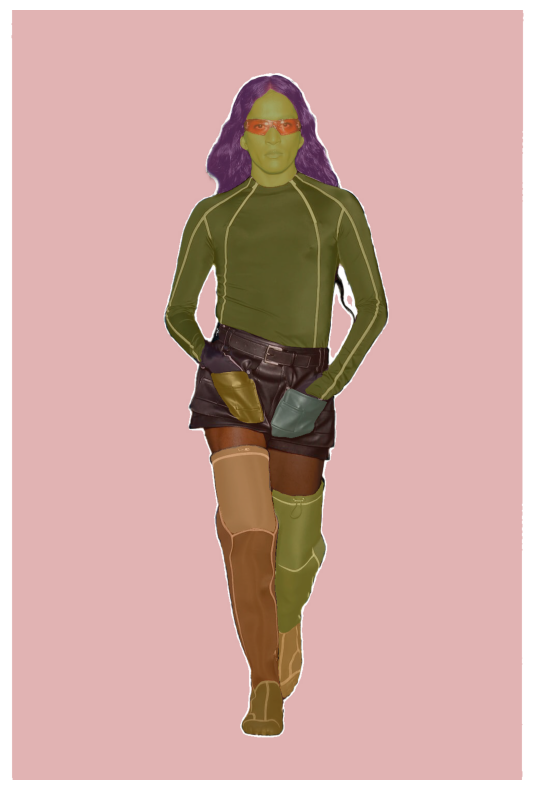

In [7]:

masks = mask_generator.generate(image)

print(len(masks))
plt.figure(figsize=(10,10))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

In [8]:
import PIL
def generate_mask_captions(image, masks, cls_lists): 
    #Tensor.cpu(image)
    # model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-B-32", is_eval=True, device=device)
    model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-L-14-336", is_eval=True, device=device)
    
    garment_data = []
    
    for n in range(len(masks)): 
        
        img_data = []
        crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

        if crop_mode == "wo_bg":
            masked_image = image * masks[n]['segmentation'][:,:,np.newaxis] + (1 - masks[n]['segmentation'][:,:,np.newaxis]) * 255
            masked_image = np.uint8(masked_image)
        else:
            masked_image = np.array(image)
        masked_image = PIL.Image.fromarray(masked_image)

        #display(masked_image.resize((width // 3, height // 3)))
        size = max(masks[n]['segmentation'].shape[0], masks[n]['segmentation'].shape[1])
        left, top, right, bottom = seg_to_box(masks[n]['segmentation'], size) # calculating the position of the top-left and bottom-right corners in the image
        #print(left, top, right, bottom)

        image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
        #display(image_crop)
        
        
        #for prompt in text_prompts:
            #inputs = processor(image_crop, text = prompt, return_tensors = "pt").to(device, torch_dtype)
            #out = captioning_model.generate(**inputs, max_new_tokens = 200)
            #captions = processor.decode(out[0], skip_special_tokens = True).strip()
        
            #img_data.append(captions)
        
        #details.append(img_data)
        
        
        segment_data = [] 
        for key, cls_list in cls_lists.items(): 
            
            cls_names = [txt_processors["eval"](cls_nm) for cls_nm in cls_list]
            image_piece = vis_processors["eval"](image_crop).unsqueeze(0).to(device)
            
            sample = {"image": image_piece, "text_input": cls_names}

            clip_features = model.extract_features(sample)

            image_features = clip_features.image_embeds_proj
            text_features = clip_features.text_embeds_proj
            
            sims = (image_features @ text_features.t())[0] / 0.01
            probs = torch.nn.Softmax(dim=0)(sims).tolist()

            #for cls_nm, prob in zip(cls_names, probs):
                #print(f"{cls_nm}: \t {prob:.3%}")
            
            parsed = pd.DataFrame(zip(cls_names, probs), columns=['option', 'prob'])
            try:
                parsed = parsed.sort_values("prob", ascending=False).iloc[0:3]
            except: 
                parsed = parsed.sort_values("prob", ascending=False).iloc[0]

            segment_data.append((parsed['option'] + parsed['prob'].astype(str).apply(lambda x: ':'+x[:5])).values)
        
        garment_data.append(segment_data)
        image_crop.save(f'./dissected_garment/{Path(IMG_PATH).stem}_{n:03}.jpg')
        
    garment_data_parsed = pd.DataFrame(garment_data, columns=cls_lists.keys())
    return garment_data_parsed
        

In [9]:
import PIL
def generate_mask_captions_from_taxonomy(image, masks, taxonomy): 
    #Tensor.cpu(image)
    # model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-B-32", is_eval=True, device=device)
    model, vis_processors, txt_processors = load_model_and_preprocess("clip_feature_extractor", model_type="ViT-L-14-336", is_eval=True, device=device)
    
    garment_data = []
    
    for n in range(len(masks)): 
        
        img_data = []
        crop_mode = "wo_bg" # Optional['wo_bg', 'w_bg'], where w_bg and wo_bg refer to remain and discard background separately.

        if crop_mode == "wo_bg":
            masked_image = image * masks[n]['segmentation'][:,:,np.newaxis] + (1 - masks[n]['segmentation'][:,:,np.newaxis]) * 255
            masked_image = np.uint8(masked_image)
        else:
            masked_image = np.array(image)
        masked_image = PIL.Image.fromarray(masked_image)

        #display(masked_image.resize((width // 3, height // 3)))
        size = max(masks[n]['segmentation'].shape[0], masks[n]['segmentation'].shape[1])
        left, top, right, bottom = seg_to_box(masks[n]['segmentation'], size) # calculating the position of the top-left and bottom-right corners in the image
        #print(left, top, right, bottom)

        image_crop = masked_image.crop((left * size, top * size, right * size, bottom * size)) # crop the image
        #display(image_crop)
        
        
        #for prompt in text_prompts:
            #inputs = processor(image_crop, text = prompt, return_tensors = "pt").to(device, torch_dtype)
            #out = captioning_model.generate(**inputs, max_new_tokens = 200)
            #captions = processor.decode(out[0], skip_special_tokens = True).strip()
        
            #img_data.append(captions)
        
        #details.append(img_data)
        
        
        results = classify_garment(taxonomy, '', image_crop, model, vis_processors, txt_processors)
        
        garment_data.append(results)
        image_crop.save(f'./dissected_garment/{Path(IMG_PATH).stem}_{n:03}.jpg')
        
        
    garment_data_parsed = pd.DataFrame(garment_data)
    return garment_data_parsed
        

In [10]:
import pandas as pd
import torch

def classify_garment(taxonomy, desc, image_crop, model, vis_processors, txt_processors, results=None):
    
    if results is None:
        results = []
        
    try:
        cls_names = [txt_processors["eval"](cls_nm) for cls_nm in taxonomy.keys()]
    except AttributeError as e: 
        #print(e)
        cls_names = [txt_processors["eval"](cls_nm) for cls_nm in taxonomy]
        
    image_piece = vis_processors["eval"](image_crop).unsqueeze(0).to(device)
    sample = {"image": image_piece, "text_input": cls_names}
    
    clip_features = model.extract_features(sample)

    image_features = clip_features.image_embeds_proj
    text_features = clip_features.text_embeds_proj

    sims = (image_features @ text_features.t())[0] / 0.01
    probs = torch.nn.Softmax(dim=0)(sims).tolist()
    
    parsed = pd.DataFrame(zip(cls_names, probs), columns=['option', 'prob'])
    parsed = parsed.sort_values("prob", ascending=False).iloc[0]
    max_cls = parsed['option']
    results.append({'question': desc, 'option': max_cls, 'prob': parsed['prob']})
    #print(max_cls)
    try: 
        if isinstance(taxonomy[max_cls], dict):
            for desc in taxonomy[max_cls].keys(): 
                if not isinstance(taxonomy[max_cls][desc], dict):
                    #print("not dict")
                    classify_garment(taxonomy[max_cls][desc], desc, image_crop, model, vis_processors, txt_processors, results)
            #print("dict")    
            classify_garment(taxonomy[max_cls], '', image_crop, model, vis_processors, txt_processors, results)
    except TypeError as e:
        #print(e)
        pass

    results = pd.DataFrame(results)

    return (results['question']+'?'+(results['option'] + ':' + results['prob'].astype(str).apply(lambda x: ':' + x[:5]))).str.cat(sep=', ')
    


In [11]:
import json 
TAXONOMY_PATH = '/share/ju/segmentation/unravel/fashion-taxonomy.json'
taxonomy = json.load(open(TAXONOMY_PATH))

In [12]:
garment_data = generate_mask_captions_from_taxonomy(image, masks, taxonomy)

In [13]:
garment_data

,0
0,"?Clothing::0.699, ?Clothing/Upper::0.344, Laye..."
1,"?Clothing::0.977, ?Clothing/Upper::0.939, Laye..."
2,"?Clothing::0.715, ?Clothing/Upper::0.362, Laye..."
3,"?Bags::0.432, ?Bags/Luggage::0.454, Color?brow..."
4,"?Footwear::0.470, ?Footwear/Rubber Boots::0.84..."
5,"?Accessories::0.413, ?Accessories/Eyewear::0.9..."
6,"?Footwear::0.509, ?Footwear/Rubber Boots::0.29..."
7,"?Clothing::0.580, ?Clothing/Upper::0.489, Laye..."
8,"?Bags::0.332, ?Bags/Backpacks::0.465, Color?re..."
9,"?Watch::0.470, Case color?golden watch::0.590,..."


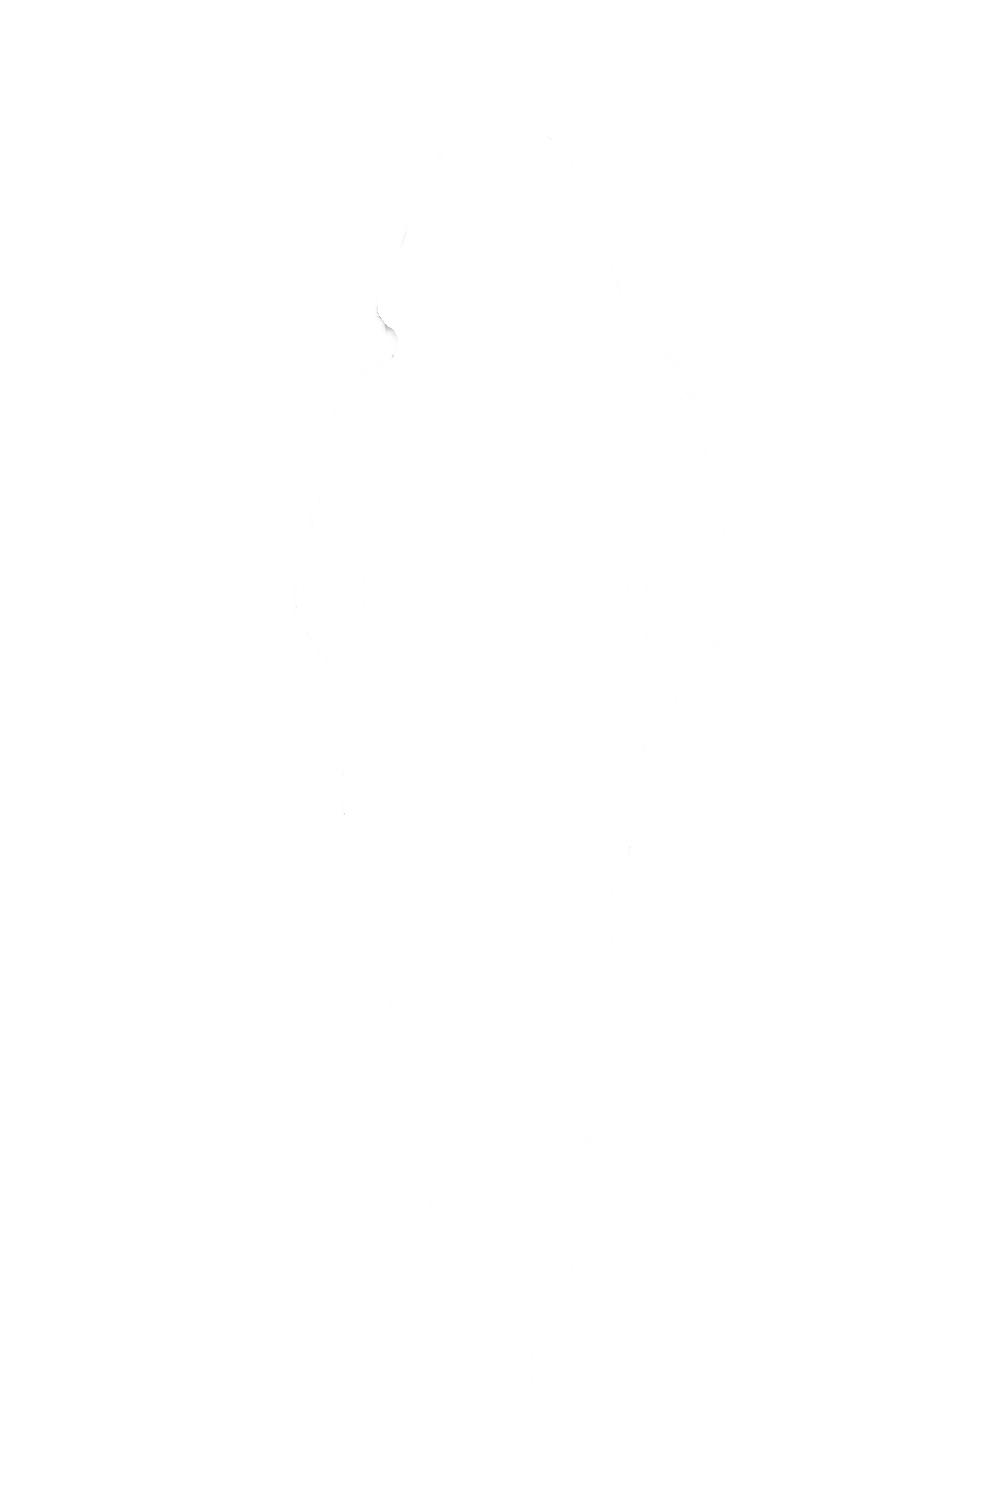

['?Clothing::0.699, ?Clothing/Upper::0.344, Layers?2nd layer::0.617, Closure?full closure::0.545, Fastening?no fastening::0.540, Fastening type?drawstrings::0.250, Lining?single-breasted::0.873, Color?white::0.623, Cut?shorted::0.304, Design?text::0.601, Pattern?other::0.410, Neckline?square::0.169, Age?adult::0.734, Belt?no belt::0.566, Type?drawstrings::0.250, Gender?men::0.697, Hood?not visible::0.946, Material?linen::0.710, Sleeves?3/4 sleeves::0.361, Style?sport::0.628, Subcategory?shirts::0.120, ?Cut::0.200']

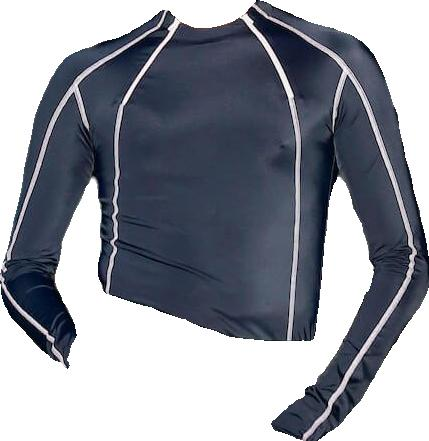

['?Clothing::0.977, ?Clothing/Upper::0.939, Layers?2nd layer::0.868, Closure?full closure::0.561, Fastening?fastening::0.565, Fastening type?toggles::0.385, Lining?single-breasted::0.975, Color?dark blue and navy::0.718, Cut?shoulder straps::0.959, Design?text::0.753, Pattern?other::0.493, Neckline?boatneck::0.963, Age?adult::0.931, Belt?belt::0.538, Type?toggles::0.385, Gender?unisex::0.981, Hood?not visible::0.918, Material?mesh/transparent::0.716, Sleeves?long sleeves::0.919, Style?sport::0.976, Subcategory?transparent tops::0.975, ?Fastening type::0.269']

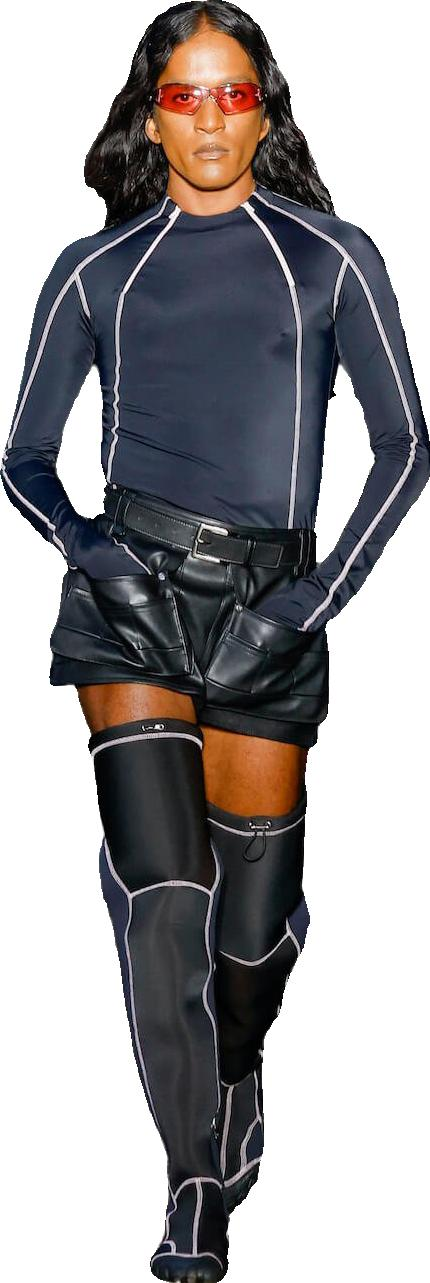

['?Clothing::0.715, ?Clothing/Upper::0.362, Layers?2nd layer::0.844, Closure?full closure::0.667, Fastening?no fastening::0.559, Fastening type?buckle::0.846, Lining?single-breasted::0.930, Color?black::0.637, Cut?shorted::0.594, Design?melange::0.682, Pattern?animalistic::0.350, Neckline?turtleneck::0.150, Age?adult::0.814, Belt?no belt::0.677, Type?buckle::0.846, Gender?unisex::0.933, Hood?not visible::0.642, Material?leather::0.695, Sleeves?short sleeves::0.594, Style?sport::0.461, Subcategory?transparent tops::0.581, ?Style::0.204']

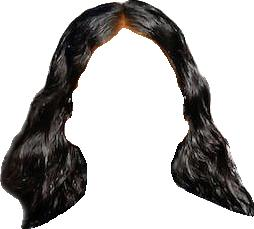

['?Bags::0.432, ?Bags/Luggage::0.454, Color?brown::0.645, Material?suede::0.620, Subcategory?suitcases::0.484, ?Subcategory::0.623']

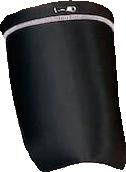

['?Footwear::0.470, ?Footwear/Rubber Boots::0.849, Color?black::0.909, Gender?men::0.513, Heel height?not visible::0.612, Heel shape?Normal sole::0.898, Height?middle boots::0.582, Material?rubber and plastic shoes::0.418, Style?sport::0.929, ?Heel shape::0.772']

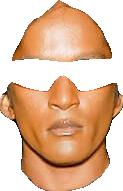

['?Accessories::0.413, ?Accessories/Eyewear::0.997, Subcategory?sunglasses::0.988, ?Subcategory::1.0']

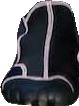

['?Footwear::0.509, ?Footwear/Rubber Boots::0.293, Color?black::0.722, Gender?men::0.926, Heel height?middle::0.684, Heel shape?Normal sole::0.705, Height?middle boots::0.579, Material?rubber and plastic shoes::0.341, Style?sport::0.924, ?Heel shape::0.773']

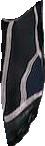

['?Clothing::0.580, ?Clothing/Upper::0.489, Layers?2nd layer::0.807, Closure?partial closure::0.455, Fastening?fastening::0.514, Fastening type?toggles::0.375, Lining?single-breasted::0.979, Color?dark blue and navy::0.566, Cut?shoulder straps::0.952, Design?text::0.578, Pattern?chevron::0.337, Neckline?one shoulder::0.387, Age?adult::0.734, Belt?belt::0.862, Type?toggles::0.375, Gender?men::0.751, Hood?not visible::0.973, Material?linen::0.242, Sleeves?one sleeve::0.808, Style?sport::0.915, Subcategory?vests::0.338, ?Age::0.411']

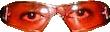

['?Bags::0.332, ?Bags/Backpacks::0.465, Color?red::0.723, Material?straw::0.479, Subcategory?backpack purse::0.318, ?Subcategory::0.808']

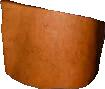

["?Watch::0.470, Case color?golden watch::0.590, Dial color?golden dial::0.406, Dial type?Non-numeric dial::0.422, Gemstones?watch without gemstones/rhinestones::0.840, Gender?men's watch::0.611, Strap color?brown strap::0.980, Strap material?leather::0.640, Style?sport::0.965, Type?digital watch::0.732, Subcategory?formal sandals::0.596, ?Strap color::0.803"]

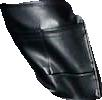

['?Clothing::0.415, ?Clothing/Upper::0.541, Layers?2nd layer::0.774, Closure?full closure::0.537, Fastening?fastening::0.821, Fastening type?zipper::0.511, Lining?single-breasted::0.956, Color?black::0.936, Cut?strapless::0.524, Design?text::0.952, Pattern?other::0.894, Neckline?back::0.250, Age?adult::0.500, Belt?belt::0.834, Type?zipper::0.511, Gender?men::0.507, Hood?not visible::0.899, Material?leather::0.975, Sleeves?one sleeve::0.516, Style?sport::0.963, Subcategory?vests::0.289, ?Belt::0.630']

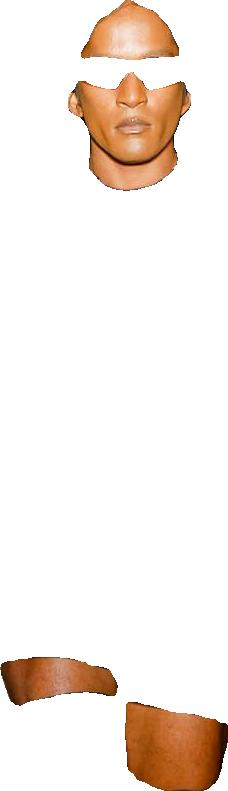

['?Clothing::0.464, ?Clothing/Upper::0.244, Layers?2nd layer::0.610, Closure?full closure::0.471, Fastening?no fastening::0.516, Fastening type?toggles::0.467, Lining?single-breasted::0.866, Color?white::0.228, Cut?shorted::0.806, Design?text::0.473, Pattern?checked::0.395, Neckline?square::0.230, Age?adult::0.619, Belt?belt::0.630, Type?toggles::0.467, Gender?men::0.423, Hood?not visible::0.501, Material?linen::0.558, Sleeves?3/4 sleeves::0.311, Style?casual::0.569, Subcategory?tops::0.166, ?Subcategory::0.220']

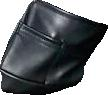

['?Footwear::0.538, ?Footwear/Rubber Boots::0.430, Color?black::0.771, Gender?men::0.502, Heel height?middle::0.540, Heel shape?Normal sole::0.636, Height?middle boots::0.462, Material?leather/faux leather shoes::0.511, Style?sport::0.644, ?Heel shape::0.883']

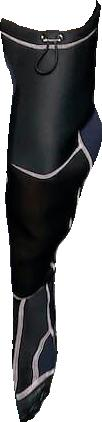

['?Clothing::0.408, ?Clothing/Pants::0.509, Age?children::0.631, Color?black::0.821, Design?text::0.791, Pattern?other::0.597, Gender?men::0.777, Length?long::0.876, Fit?slim::0.464, Material?leather::0.293, Rise?mid rise::0.517, Style?sport::0.959, Subcategory?sportswear leggings::0.421, ?Age::0.271']

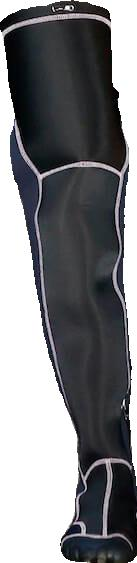

['?Clothing::0.824, ?Clothing/Pants::0.801, Age?adult::0.639, Color?silver::0.248, Design?text::0.626, Pattern?stripe::0.473, Gender?men::0.847, Length?long::0.843, Fit?wide leg::0.481, Material?corduroy::0.441, Rise?mid rise::0.685, Style?sport::0.900, Subcategory?casual trousers::0.303, ?Age::0.441']

In [14]:
from IPython.display import Image
for idx, row in garment_data.iterrows(): 
    #display_side_by_side(Image(f'./dissected_garment/{idx:03}.jpg', width=300), row)
    display(Image(f'./dissected_garment/{Path(IMG_PATH).stem}_{idx:03}.jpg', width=450))
    
    display(list(row))
    

In [15]:
# Future Work 
## Optimal number of feature extraction categories -> may have too many categories for 'fit', 'style', etc. 
## 'Geostyle' spin-off 
## Tradeoff between SUPER small segmentations (cuffs can look like hats when not attached to sleeves, etc.) -> need to figure out how to manage this 
